## End-to-End Text-to-Image Transformer Implementation (Feature Generation)

### Introduction: Generating Images from Text via Feature Vectors

**Recap: The Multi-Modal Transformer**

In `multimodal.ipynb`, we adapted our character-level Transformer to handle both images (via ResNet features) and text prompts for tasks like visual description. We saved the state, including text processing components, tokenizer, and the vision feature projection layer, in `saved_models/multimodal_model.pt`.

**The Text-to-Image Challenge (Simplified)**

Generating realistic images directly from text is a complex task often involving specialized architectures like Generative Adversarial Networks (GANs) or Diffusion Models. To stay within our inline, Transformer-focused framework, we will tackle a simplified version:

*   **Goal:** Given a text prompt (e.g., "a blue square"), generate an *image feature vector* that represents the described image.
*   **Why Feature Vectors?** Generating raw pixels autoregressively with a basic Transformer is difficult and computationally expensive. Generating a fixed-size feature vector (like those from ResNet) is a more manageable intermediate step.
*   **Image Reconstruction:** After generating the feature vector, we will use a simple nearest-neighbor approach on our known training images to visualize the result. The model predicts a feature vector, and we find which of our training images (red square, blue square, green circle) has the most similar feature vector, displaying that image.

**Our Approach: Transformer for Feature Prediction**

1.  **Load Components:** We load the text Transformer components (embeddings, positional encoding, attention/FFN blocks, final layer norm) and the tokenizer from `multimodal_model.pt`. We also load the frozen ResNet-18 feature extractor to get *target* features during training.
2.  **Adapt Architecture:** The input is now only text. We will replace the final output layer (which previously predicted text tokens) with a new linear layer that maps the Transformer's final hidden state to the dimensionality of the ResNet image features (e.g., 512).
3.  **Training Data:** We need pairs of (Text Prompt, Target Image). We'll use descriptive prompts for the simple images created previously.
4.  **Training Process:** The model reads the prompt, processes it through the Transformer blocks, and uses the new output layer to predict an image feature vector. The loss (MSE) compares this predicted vector to the *actual* feature vector of the target image.
5.  **Inference (Generation):** Input a text prompt, get the predicted feature vector from the model, find the closest matching known image feature, and display the corresponding image.

**Inline Implementation Style**

We continue the extremely detailed, step-by-step, inline implementation with theory, avoiding functions and classes.

### Step 0: Setup - Libraries, Loading, Data, Feature Extraction

**Goal:** Prepare the environment, load relevant components from the previous multi-modal model, define text-image pair data, and extract target image features.

#### Step 0.1: Import Libraries

**Theory:** Import necessary libraries. We need `torch`, `torchvision`, `PIL`, `math`, `os`, `numpy`. We'll also need `scipy.spatial.distance` or `torch.nn.functional.cosine_similarity` later for finding the closest feature vector during generation.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageDraw # Added ImageDraw back
import math
import os
import numpy as np
# For finding closest vector later
from scipy.spatial import distance as scipy_distance 

# For reproducibility
torch.manual_seed(123) # Yet another seed
np.random.seed(123)

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print("Libraries imported.")

# --- Device Configuration ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

PyTorch version: 2.6.0+cu118
Torchvision version: 0.21.0+cu118
Libraries imported.
Using device: cuda


#### Step 0.2: Load Relevant State from Multi-Modal Model

**Theory:** Load the state dictionary from `multimodal_model.pt`. We need the configuration, the tokenizer, the text Transformer components (embeddings, blocks, etc.), and the ResNet feature extractor (which we'll keep frozen).

In [2]:
# --- Load Saved Multi-Modal Model State ---
print("\nStep 0.2: Loading state from multi-modal model...")
model_load_path = 'saved_models/multimodal_model.pt'
if not os.path.exists(model_load_path):
    raise FileNotFoundError(f"Error: Model file not found at {model_load_path}. Please ensure 'multimodal.ipynb' was run and saved the model.")

loaded_state_dict = torch.load(model_load_path, map_location=device)
print(f"Loaded state dictionary from '{model_load_path}'.")

# --- Extract Config and Tokenizer ---
config = loaded_state_dict['config']
vocab_size = config['vocab_size'] # Includes special tokens
d_model = config['d_model']
n_heads = config['n_heads']
n_layers = config['n_layers']
d_ff = config['d_ff']
# Use block_size from loaded config, might adjust later based only on text prompt length needs
block_size = config['block_size']
vision_feature_dim = config['vision_feature_dim'] # Dimension of ResNet features (e.g., 512)
d_k = d_model // n_heads

char_to_int = loaded_state_dict['tokenizer']['char_to_int']
int_to_char = loaded_state_dict['tokenizer']['int_to_char']
pad_token_id = char_to_int.get('<PAD>', -1) # Get PAD token ID
if pad_token_id == -1:
    print("Warning: PAD token not found in loaded tokenizer!")

print("Extracted model configuration and tokenizer:")
print(f"  vocab_size: {vocab_size}")
print(f"  d_model: {d_model}")
print(f"  n_layers: {n_layers}")
print(f"  n_heads: {n_heads}")
print(f"  d_ff: {d_ff}")
print(f"  block_size: {block_size}")
print(f"  vision_feature_dim: {vision_feature_dim}")
print(f"  PAD token ID: {pad_token_id}")

# --- Load Positional Encoding --- 
positional_encoding = loaded_state_dict['positional_encoding'].to(device)
# Verify block size consistency
if positional_encoding.shape[1] != block_size:
    print(f"Warning: Loaded PE size ({positional_encoding.shape[1]}) doesn't match loaded block_size ({block_size}). Using loaded PE size.")
    # block_size = positional_encoding.shape[1] # Option 1: Use PE's size
    # Option 2: Recompute PE (like before) if necessary, but let's try slicing/padding first if needed
print(f"Loaded positional encoding with shape: {positional_encoding.shape}")

# --- Load Text Transformer Components (Weights only, structure created later) ---
loaded_embedding_dict = loaded_state_dict['token_embedding_table']
loaded_ln1_dicts = loaded_state_dict['layer_norms_1']
loaded_qkv_dicts = loaded_state_dict['mha_qkv_linears']
loaded_mha_out_dicts = loaded_state_dict['mha_output_linears']
loaded_ln2_dicts = loaded_state_dict['layer_norms_2']
loaded_ffn1_dicts = loaded_state_dict['ffn_linear_1']
loaded_ffn2_dicts = loaded_state_dict['ffn_linear_2']
loaded_final_ln_dict = loaded_state_dict['final_layer_norm']
print("Stored state dicts for text transformer components.")

# --- Load Vision Feature Extractor (ResNet) --- 
# Theory: Re-load the same ResNet-18 model used before. Keep it frozen.
print("Loading pre-trained vision model (ResNet-18) for target feature extraction...")
vision_model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
vision_model.fc = nn.Identity() # Remove classifier
vision_model = vision_model.to(device)
vision_model.eval() # Keep in evaluation mode
# Freeze ResNet parameters - VERY IMPORTANT
for param in vision_model.parameters():
    param.requires_grad = False
print(f"Loaded and froze ResNet-18 feature extractor on device: {device}")

# --- Define Image Transformations (same as before) ---
image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
print("Defined image transformations.")


Step 0.2: Loading state from multi-modal model...
Loaded state dictionary from 'saved_models/multimodal_model.pt'.
Extracted model configuration and tokenizer:
  vocab_size: 42
  d_model: 64
  n_layers: 3
  n_heads: 4
  d_ff: 256
  block_size: 64
  vision_feature_dim: 512
  PAD token ID: 37
Loaded positional encoding with shape: torch.Size([1, 64, 64])
Stored state dicts for text transformer components.
Loading pre-trained vision model (ResNet-18) for target feature extraction...
Loaded and froze ResNet-18 feature extractor on device: cuda
Defined image transformations.


#### Step 0.3: Define Sample Text-to-Image Data

**Theory:** Create pairs of (descriptive text prompt, path_to_target_image). Use the same simple images generated in the previous notebook.

In [3]:
print("\nStep 0.3: Defining sample text-to-image data...")

# --- Image Paths (Assuming they exist from multimodal.ipynb) ---
sample_data_dir = "sample_multimodal_data"
image_paths = {
    "red_square": os.path.join(sample_data_dir, "red_square.png"),
    "blue_square": os.path.join(sample_data_dir, "blue_square.png"),
    "green_circle": os.path.join(sample_data_dir, "green_circle.png")
}
# Verify paths exist
for key, path in image_paths.items():
    if not os.path.exists(path):
        print(f"Warning: Image file not found at {path}. Attempting to recreate.")
        if key == "red_square":
            img_ = Image.new('RGB', (64, 64), color = 'red')
            img_.save(path)
        elif key == "blue_square":
            img_ = Image.new('RGB', (64, 64), color = 'blue')
            img_.save(path)
        elif key == "green_circle":
            img_ = Image.new('RGB', (64, 64), color = 'white')
            draw = ImageDraw.Draw(img_)
            draw.ellipse((4, 4, 60, 60), fill='green', outline='green')
            img_.save(path)
        else:
             print(f"Error: Cannot recreate unknown image key '{key}'.")

# --- Define Text Prompt -> Image Path Pairs ---
text_to_image_data = [
    {"prompt": "a red square", "image_path": image_paths["red_square"]},
    {"prompt": "the square is red", "image_path": image_paths["red_square"]},
    {"prompt": "show a blue square", "image_path": image_paths["blue_square"]},
    {"prompt": "blue shape, square", "image_path": image_paths["blue_square"]},
    {"prompt": "a green circle", "image_path": image_paths["green_circle"]},
    {"prompt": "the circle, it is green", "image_path": image_paths["green_circle"]},
    # Add maybe one more variation
    {"prompt": "make a square that is red", "image_path": image_paths["red_square"]}
]

num_samples = len(text_to_image_data)
print(f"Defined {num_samples} sample text-to-image data points.")
# print(f"Sample 0: {text_to_image_data[0]}")


Step 0.3: Defining sample text-to-image data...
Defined 7 sample text-to-image data points.


#### Step 0.4: Extract Target Image Features

**Theory:** Pre-compute the target feature vectors for all unique images in our dataset using the frozen ResNet. Store these, mapping the image path to its feature tensor. We also store them in a separate list alongside their paths for the nearest-neighbor lookup during generation.

In [4]:
print("\nStep 0.4: Extracting target image features...")
target_image_features = {} # Dict: {image_path: feature_tensor}
known_features_list = [] # List: [(path, feature_tensor)] for generation lookup

# --- Loop Through Unique Image Paths in this dataset ---
unique_image_paths_in_data = sorted(list(set(d["image_path"] for d in text_to_image_data)))
print(f"Found {len(unique_image_paths_in_data)} unique target images to process.")

for img_path in unique_image_paths_in_data:
    # Avoid re-extracting if already done (e.g., if loading from multimodal)
    # if img_path in extracted_image_features: # Check previous notebook's dict
    #    feature_vector_squeezed = extracted_image_features[img_path]
    #    print(f"  Using pre-extracted features for '{os.path.basename(img_path)}'")
    # else: 
    # --- Load Image --- 
    try:
        img = Image.open(img_path).convert('RGB')
    except FileNotFoundError:
        print(f"Error: Image file not found at {img_path}. Skipping.")
        continue
    
    # --- Apply Transformations ---
    img_tensor = image_transforms(img).unsqueeze(0).to(device) # (1, 3, 224, 224)

    # --- Extract Features (using frozen vision_model) ---
    with torch.no_grad():
        feature_vector = vision_model(img_tensor) # (1, vision_feature_dim)
    feature_vector_squeezed = feature_vector.squeeze(0) # (vision_feature_dim,)
    print(f"  Extracted features for '{os.path.basename(img_path)}', shape: {feature_vector_squeezed.shape}")

    # --- Store Features ---
    target_image_features[img_path] = feature_vector_squeezed
    known_features_list.append((img_path, feature_vector_squeezed))

if not target_image_features:
     raise ValueError("No target image features were extracted. Cannot proceed.")

print("Finished extracting and storing target image features.")
print(f"Stored {len(known_features_list)} known (path, feature) pairs for generation lookup.")


Step 0.4: Extracting target image features...
Found 3 unique target images to process.
  Extracted features for 'blue_square.png', shape: torch.Size([512])
  Extracted features for 'green_circle.png', shape: torch.Size([512])
  Extracted features for 'red_square.png', shape: torch.Size([512])
Finished extracting and storing target image features.
Stored 3 known (path, feature) pairs for generation lookup.


#### Step 0.5: Define Training Hyperparameters

**Theory:** Adjust hyperparameters for this specific task. We might need a different learning rate or number of epochs. The `block_size` here mainly relates to the maximum prompt length we expect.

In [5]:
print("\nStep 0.5: Defining training hyperparameters for text-to-image...")

# Use block_size from loaded config, ensure it's adequate for prompts
max_prompt_len = max(len(d["prompt"]) for d in text_to_image_data)
if block_size < max_prompt_len + 1: # +1 for potential special tokens like <EOS> if used in prompt
    print(f"Warning: Loaded block_size ({block_size}) might be small for max prompt length ({max_prompt_len}). Consider increasing block_size if issues arise.")
    # Adjust block_size if needed, and recompute PE / causal mask
    # block_size = max_prompt_len + 5 # Example adjustment
    # print(f"Adjusted block_size to {block_size}")
    # Need to recompute PE and causal_mask if block_size changes

# Recreate causal mask just in case block_size was adjusted, or use loaded size
causal_mask = torch.tril(torch.ones(block_size, block_size, device=device)).view(1, 1, block_size, block_size)
print(f"Using block_size: {block_size}")

learning_rate = 1e-4 # Potentially lower LR for fine-tuning
batch_size = 4      # Keep small due to limited data
epochs = 5000       # Number of training iterations
eval_interval = 500

print(f"  Training Params: LR={learning_rate}, BatchSize={batch_size}, Epochs={epochs}")


Step 0.5: Defining training hyperparameters for text-to-image...
Using block_size: 64
  Training Params: LR=0.0001, BatchSize=4, Epochs=5000


### Step 1: Model Adaptation and Initialization

**Goal:** Rebuild the text Transformer components using the loaded weights and initialize the new output projection layer.

#### Step 1.1: Initialize Text Transformer Components

**Theory:** Create instances of the embedding layer, LayerNorms, and Linear layers for the Transformer blocks, then load the pre-trained weights from the dictionaries stored in Step 0.2.

In [6]:
print("\nStep 1.1: Initializing Text Transformer components and loading weights...")

# --- Token Embedding Table ---
token_embedding_table = nn.Embedding(vocab_size, d_model).to(device)
token_embedding_table.load_state_dict(loaded_embedding_dict)
print(f"  Loaded Token Embedding Table, shape: {token_embedding_table.weight.shape}")

# --- Transformer Blocks Components ---
layer_norms_1 = []
mha_qkv_linears = []
mha_output_linears = []
layer_norms_2 = []
ffn_linear_1 = []
ffn_linear_2 = []

for i in range(n_layers):
    # LayerNorm 1
    ln1 = nn.LayerNorm(d_model).to(device)
    ln1.load_state_dict(loaded_ln1_dicts[i])
    layer_norms_1.append(ln1)

    # MHA QKV Linear (Check bias presence)
    qkv_dict = loaded_qkv_dicts[i]
    has_bias = 'bias' in qkv_dict
    qkv_linear = nn.Linear(d_model, 3 * d_model, bias=has_bias).to(device)
    qkv_linear.load_state_dict(qkv_dict)
    mha_qkv_linears.append(qkv_linear)

    # MHA Output Linear (Check bias presence)
    mha_out_dict = loaded_mha_out_dicts[i]
    has_bias = 'bias' in mha_out_dict
    output_linear_mha = nn.Linear(d_model, d_model, bias=has_bias).to(device)
    output_linear_mha.load_state_dict(mha_out_dict)
    mha_output_linears.append(output_linear_mha)

    # LayerNorm 2
    ln2 = nn.LayerNorm(d_model).to(device)
    ln2.load_state_dict(loaded_ln2_dicts[i])
    layer_norms_2.append(ln2)

    # FFN Linear 1 (Check bias presence)
    ffn1_dict = loaded_ffn1_dicts[i]
    has_bias = 'bias' in ffn1_dict
    lin1 = nn.Linear(d_model, d_ff, bias=has_bias).to(device)
    lin1.load_state_dict(ffn1_dict)
    ffn_linear_1.append(lin1)

    # FFN Linear 2 (Check bias presence)
    ffn2_dict = loaded_ffn2_dicts[i]
    has_bias = 'bias' in ffn2_dict
    lin2 = nn.Linear(d_ff, d_model, bias=has_bias).to(device)
    lin2.load_state_dict(ffn2_dict)
    ffn_linear_2.append(lin2)

print(f"  Loaded components for {n_layers} Transformer Layers.")

# --- Final LayerNorm ---
final_layer_norm = nn.LayerNorm(d_model).to(device)
final_layer_norm.load_state_dict(loaded_final_ln_dict)
print("  Loaded Final LayerNorm.")

print("Finished initializing and loading weights for text transformer components.")


Step 1.1: Initializing Text Transformer components and loading weights...
  Loaded Token Embedding Table, shape: torch.Size([42, 64])
  Loaded components for 3 Transformer Layers.
  Loaded Final LayerNorm.
Finished initializing and loading weights for text transformer components.


#### Step 1.2: Initialize New Output Projection Layer

**Theory:** Create the new linear layer that will map the final hidden state of the Transformer (`d_model`) to the dimension of the image feature vector (`vision_feature_dim`). This layer's weights are initialized randomly and will be trained.

In [7]:
print("\nStep 1.2: Initializing new output projection layer (Text -> Image Feature)...")

text_to_image_feature_layer = nn.Linear(d_model, vision_feature_dim).to(device)

print(f"  Initialized Text-to-Image-Feature Output Layer: {d_model} -> {vision_feature_dim}. Device: {device}")


Step 1.2: Initializing new output projection layer (Text -> Image Feature)...
  Initialized Text-to-Image-Feature Output Layer: 64 -> 512. Device: cuda


### Step 2: Data Preparation for Text-to-Image Training

**Goal:** Tokenize and pad the text prompts, and pair them with their corresponding target image feature vectors.

#### Step 2.1: Tokenize and Pad Prompts

**Theory:** Convert text prompts into sequences of token IDs using `char_to_int`. Pad each sequence to `block_size` using `pad_token_id`. Also create corresponding attention masks (1 for real tokens, 0 for padding).

In [8]:
print("\nStep 2.1: Tokenizing and padding text prompts...")

prepared_prompts = []
target_features_ordered = [] # Store target features in the same order

for sample in text_to_image_data:
    prompt = sample["prompt"]
    image_path = sample["image_path"]

    # --- Tokenize Prompt --- 
    prompt_ids_no_pad = [char_to_int[ch] for ch in prompt]

    # --- Padding --- 
    current_len = len(prompt_ids_no_pad)
    pad_len = block_size - current_len

    if pad_len < 0:
        print(f"Warning: Prompt length ({current_len}) exceeds block_size ({block_size}). Truncating prompt.")
        prompt_ids = prompt_ids_no_pad[:block_size]
        pad_len = 0
        current_len = block_size
    else:
        prompt_ids = prompt_ids_no_pad + ([pad_token_id] * pad_len)

    # --- Create Attention Mask --- 
    attention_mask = ([1] * current_len) + ([0] * pad_len)

    # --- Store Prompt Data --- 
    prepared_prompts.append({
        "input_ids": torch.tensor(prompt_ids, dtype=torch.long),
        "attention_mask": torch.tensor(attention_mask, dtype=torch.long)
    })

    # --- Store Corresponding Target Feature --- 
    if image_path in target_image_features:
        target_features_ordered.append(target_image_features[image_path])
    else:
        print(f"Error: Target feature not found for {image_path}. Data mismatch?")
        # Handle error - maybe skip this sample or raise exception
        target_features_ordered.append(torch.zeros(vision_feature_dim, device=device)) # Placeholder

# --- Stack into Tensors --- 
all_prompt_input_ids = torch.stack([p['input_ids'] for p in prepared_prompts])
all_prompt_attention_masks = torch.stack([p['attention_mask'] for p in prepared_prompts])
all_target_features = torch.stack(target_features_ordered)

num_sequences_available = all_prompt_input_ids.shape[0]
print(f"Created {num_sequences_available} padded prompt sequences and gathered target features.")
print(f"  Prompt Input IDs shape: {all_prompt_input_ids.shape}") # (num_samples, block_size)
print(f"  Prompt Attention Mask shape: {all_prompt_attention_masks.shape}") # (num_samples, block_size)
print(f"  Target Features shape: {all_target_features.shape}") # (num_samples, vision_feature_dim)


Step 2.1: Tokenizing and padding text prompts...
Created 7 padded prompt sequences and gathered target features.
  Prompt Input IDs shape: torch.Size([7, 64])
  Prompt Attention Mask shape: torch.Size([7, 64])
  Target Features shape: torch.Size([7, 512])


#### Step 2.2: Batching Strategy (Random Sampling)

**Theory:** Set up for random batch sampling during training. We'll select random indices and grab the corresponding prompt IDs, masks, and target image features.

In [9]:
print("\nStep 2.2: Preparing for batching text-to-image data...")

# Check batch size feasibility
if num_sequences_available < batch_size:
    print(f"Warning: Number of sequences ({num_sequences_available}) is less than batch size ({batch_size}). Adjusting batch size.")
    batch_size = num_sequences_available

print(f"Data ready for training. Will sample batches of size {batch_size} randomly.")
# In the training loop, we will use random indices to get:
# xb_prompt_ids = all_prompt_input_ids[indices]
# batch_prompt_masks = all_prompt_attention_masks[indices]
# yb_target_features = all_target_features[indices]


Step 2.2: Preparing for batching text-to-image data...
Data ready for training. Will sample batches of size 4 randomly.


### Step 3: Text-to-Image Training Loop (Inline)

**Goal:** Train the model to map text prompts to image feature vectors.

#### Step 3.1: Define Optimizer and Loss Function

**Theory:** Gather *trainable* parameters (Transformer components + new output layer). Define the optimizer (AdamW). Define the loss function - Mean Squared Error (MSE) is suitable for comparing the predicted and target feature vectors.

In [10]:
print("\nStep 3.1: Defining Optimizer and Loss Function for text-to-image...")

# --- Gather Trainable Parameters --- 
# Includes Transformer components and the new output layer
all_trainable_parameters_t2i = list(token_embedding_table.parameters())
for i in range(n_layers):
    all_trainable_parameters_t2i.extend(list(layer_norms_1[i].parameters()))
    all_trainable_parameters_t2i.extend(list(mha_qkv_linears[i].parameters()))
    all_trainable_parameters_t2i.extend(list(mha_output_linears[i].parameters()))
    all_trainable_parameters_t2i.extend(list(layer_norms_2[i].parameters()))
    all_trainable_parameters_t2i.extend(list(ffn_linear_1[i].parameters()))
    all_trainable_parameters_t2i.extend(list(ffn_linear_2[i].parameters()))
all_trainable_parameters_t2i.extend(list(final_layer_norm.parameters()))
all_trainable_parameters_t2i.extend(list(text_to_image_feature_layer.parameters())) # Add the new layer

# --- Define Optimizer --- 
optimizer = optim.AdamW(all_trainable_parameters_t2i, lr=learning_rate)
print(f"  Optimizer defined: AdamW with lr={learning_rate}")
print(f"  Managing {len(all_trainable_parameters_t2i)} parameter groups/tensors.")

# --- Define Loss Function --- 
# Theory: MSE loss compares the predicted feature vector to the target feature vector.
criterion = nn.MSELoss()
print(f"  Loss function defined: {type(criterion).__name__}")


Step 3.1: Defining Optimizer and Loss Function for text-to-image...
  Optimizer defined: AdamW with lr=0.0001
  Managing 38 parameter groups/tensors.
  Loss function defined: MSELoss


#### Step 3.2: The Training Loop

**Theory:** Iterate for `epochs`. In each step:
1.  Select batch (prompt IDs, masks, target features).
2.  Perform forward pass: Embed prompt, add PE, pass through Transformer blocks, apply final LN, project to image feature dimension using `text_to_image_feature_layer`.
3.  Calculate MSE loss between predicted and target feature vectors.
4.  Backpropagate and update weights.


Step 3.2: Starting Text-to-Image Training Loop...
  Epoch 1/5000, MSE Loss: 0.880764
  Epoch 501/5000, MSE Loss: 0.022411
  Epoch 1001/5000, MSE Loss: 0.006695
  Epoch 1501/5000, MSE Loss: 0.000073
  Epoch 2001/5000, MSE Loss: 0.000015
  Epoch 2501/5000, MSE Loss: 0.000073
  Epoch 3001/5000, MSE Loss: 0.000002
  Epoch 3501/5000, MSE Loss: 0.000011
  Epoch 4001/5000, MSE Loss: 0.000143
  Epoch 4501/5000, MSE Loss: 0.000013
  Epoch 5000/5000, MSE Loss: 0.000030
--- Text-to-Image Training Loop Completed ---



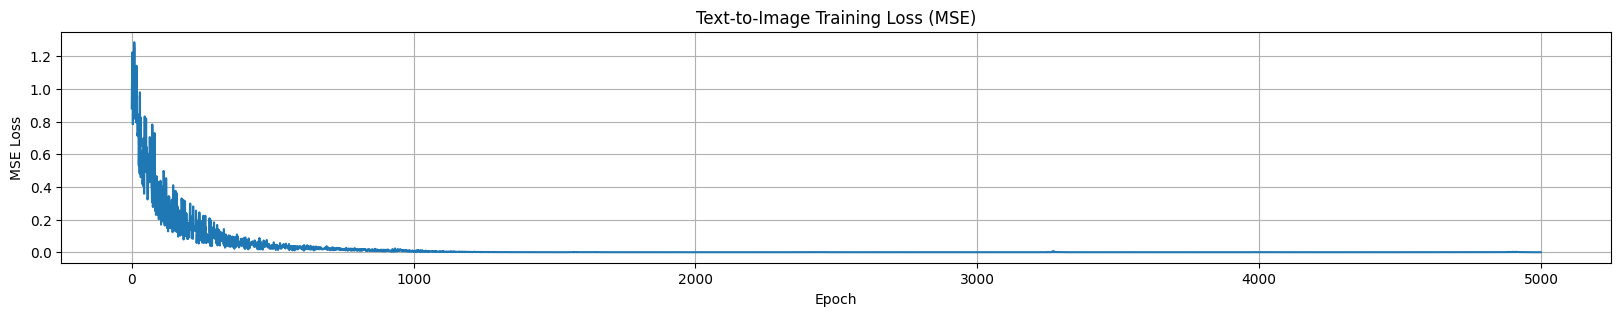

In [11]:
print("\nStep 3.2: Starting Text-to-Image Training Loop...")

t2i_losses = []

# --- Set Trainable Layers to Training Mode ---
token_embedding_table.train()
for i in range(n_layers):
    layer_norms_1[i].train()
    mha_qkv_linears[i].train()
    mha_output_linears[i].train()
    layer_norms_2[i].train()
    ffn_linear_1[i].train()
    ffn_linear_2[i].train()
final_layer_norm.train()
text_to_image_feature_layer.train() # New layer also needs training mode
# vision_model remains in eval() mode

# --- Training Loop ---
for epoch in range(epochs):

    # --- 1. Batch Selection --- 
    indices = torch.randint(0, num_sequences_available, (batch_size,))
    xb_prompt_ids = all_prompt_input_ids[indices].to(device)      # (B, T)
    batch_prompt_masks = all_prompt_attention_masks[indices].to(device) # (B, T)
    yb_target_features = all_target_features[indices].to(device) # (B, vision_feature_dim)

    # --- 2. Forward Pass --- 
    B, T = xb_prompt_ids.shape
    C = d_model

    # --- Embeddings + PE ---
    token_embed = token_embedding_table(xb_prompt_ids) # (B, T, C)
    pos_enc_slice = positional_encoding[:, :T, :]    # (1, T, C)
    x = token_embed + pos_enc_slice                # (B, T, C)

    # --- Transformer Blocks --- 
    # Create attention mask (Causal + Padding for prompts)
    padding_mask_expanded = batch_prompt_masks.unsqueeze(1).unsqueeze(2) # (B, 1, 1, T)
    combined_attn_mask = causal_mask[:,:,:T,:T] * padding_mask_expanded # (B, 1, T, T)

    for i in range(n_layers):
        x_input_block = x
        # Pre-LN MHA
        x_ln1 = layer_norms_1[i](x_input_block)
        qkv = mha_qkv_linears[i](x_ln1)
        qkv = qkv.view(B, T, n_heads, 3 * d_k).permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        attn_scores = (q @ k.transpose(-2, -1)) * (d_k ** -0.5)
        attn_scores_masked = attn_scores.masked_fill(combined_attn_mask == 0, float('-inf'))
        attention_weights = F.softmax(attn_scores_masked, dim=-1)
        attention_weights = torch.nan_to_num(attention_weights)
        attn_output = attention_weights @ v
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous().view(B, T, C)
        mha_result = mha_output_linears[i](attn_output)
        x = x_input_block + mha_result # Residual 1
        # Pre-LN FFN
        x_input_ffn = x
        x_ln2 = layer_norms_2[i](x_input_ffn)
        ffn_hidden = ffn_linear_1[i](x_ln2)
        ffn_activated = F.relu(ffn_hidden)
        ffn_output = ffn_linear_2[i](ffn_activated)
        x = x_input_ffn + ffn_output # Residual 2

    # --- Final LayerNorm --- 
    final_norm_output = final_layer_norm(x) # (B, T, C)

    # --- Select Hidden State for Prediction --- 
    # Theory: We need one vector per sequence to predict the image feature vector.
    # We can take the hidden state of the *last non-padding* token.
    # Find indices of the last non-padding token for each sequence in the batch.
    # batch_prompt_masks is (B, T), value is 1 for non-pad, 0 for pad.
    # `torch.sum(mask, 1) - 1` gives the index of the last '1'.
    last_token_indices = torch.sum(batch_prompt_masks, 1) - 1 # Shape: (B,)
    # Ensure indices are within bounds (handle case of all padding, though unlikely)
    last_token_indices = torch.clamp(last_token_indices, min=0)
    # Gather the hidden states corresponding to these last tokens.
    # We need to index final_norm_output[batch_index, token_index, :]
    batch_indices = torch.arange(B, device=device)
    last_token_hidden_states = final_norm_output[batch_indices, last_token_indices, :] # (B, C)

    # --- Project to Image Feature Dimension --- 
    # Theory: Use the new output layer to predict the image feature vector.
    predicted_image_features = text_to_image_feature_layer(last_token_hidden_states) # (B, vision_feature_dim)

    # --- 3. Calculate Loss --- 
    # Theory: Compute MSE between predicted features and target features.
    loss = criterion(predicted_image_features, yb_target_features)

    # --- 4. Zero Gradients --- 
    optimizer.zero_grad()

    # --- 5. Backward Pass --- 
    if not torch.isnan(loss) and not torch.isinf(loss):
        loss.backward()
        # Optional: Gradient Clipping
        # torch.nn.utils.clip_grad_norm_(all_trainable_parameters_t2i, max_norm=1.0)
        
        # --- 6. Update Parameters --- 
        optimizer.step()
    else:
        print(f"Warning: Invalid loss detected (NaN or Inf) at epoch {epoch+1}. Skipping optimizer step.")
        loss = None

    # --- Logging --- 
    if loss is not None:
        current_loss = loss.item()
        t2i_losses.append(current_loss)
        if epoch % eval_interval == 0 or epoch == epochs - 1:
            print(f"  Epoch {epoch+1}/{epochs}, MSE Loss: {current_loss:.6f}")
    elif epoch % eval_interval == 0 or epoch == epochs - 1:
        print(f"  Epoch {epoch+1}/{epochs}, Loss: Invalid (NaN/Inf)")

print("--- Text-to-Image Training Loop Completed ---\n")

# Optional: Plot losses
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 3))
plt.plot(t2i_losses)
plt.title("Text-to-Image Training Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

### Step 4: Text-to-Image Generation (Inline)

**Goal:** Use the trained model to generate an image feature vector from a text prompt and find the closest matching known image.

#### Step 4.1: Prepare Input Prompt

**Theory:** Define a new text prompt, tokenize it, and pad it to `block_size`.

In [12]:
print("\nStep 4.1: Preparing input prompt for generation...")

# --- Input Prompt --- 
generation_prompt_text = "a blue square shape"
print(f"Input Prompt: '{generation_prompt_text}'")

# --- Tokenize and Pad --- 
gen_prompt_ids_no_pad = [char_to_int.get(ch, pad_token_id) for ch in generation_prompt_text] # Use get with default for safety
gen_current_len = len(gen_prompt_ids_no_pad)
gen_pad_len = block_size - gen_current_len

if gen_pad_len < 0:
    print(f"Warning: Generation prompt length ({gen_current_len}) exceeds block_size ({block_size}). Truncating.")
    gen_prompt_ids = gen_prompt_ids_no_pad[:block_size]
    gen_pad_len = 0
    gen_current_len = block_size
else:
    gen_prompt_ids = gen_prompt_ids_no_pad + ([pad_token_id] * gen_pad_len)

# --- Create Attention Mask --- 
gen_attention_mask = ([1] * gen_current_len) + ([0] * gen_pad_len)

# --- Convert to Tensor --- 
xb_gen_prompt_ids = torch.tensor([gen_prompt_ids], dtype=torch.long, device=device) # Add batch dim B=1
batch_gen_prompt_masks = torch.tensor([gen_attention_mask], dtype=torch.long, device=device) # Add batch dim B=1

print(f"Prepared prompt tensor shape: {xb_gen_prompt_ids.shape}")
print(f"Prepared mask tensor shape: {batch_gen_prompt_masks.shape}")


Step 4.1: Preparing input prompt for generation...
Input Prompt: 'a blue square shape'
Prepared prompt tensor shape: torch.Size([1, 64])
Prepared mask tensor shape: torch.Size([1, 64])


#### Step 4.2: Generate Image Feature Vector

**Theory:** Perform a forward pass with the input prompt using the trained model (in evaluation mode) to get the predicted image feature vector.

In [13]:
print("\nStep 4.2: Generating image feature vector...")

# --- Set Model to Evaluation Mode --- 
token_embedding_table.eval()
for i in range(n_layers):
    layer_norms_1[i].eval()
    mha_qkv_linears[i].eval()
    mha_output_linears[i].eval()
    layer_norms_2[i].eval()
    ffn_linear_1[i].eval()
    ffn_linear_2[i].eval()
final_layer_norm.eval()
text_to_image_feature_layer.eval()

# --- Forward Pass --- 
with torch.no_grad():
    B_gen, T_gen = xb_gen_prompt_ids.shape
    C_gen = d_model

    # Embeddings + PE
    token_embed_gen = token_embedding_table(xb_gen_prompt_ids)
    pos_enc_slice_gen = positional_encoding[:, :T_gen, :]
    x_gen = token_embed_gen + pos_enc_slice_gen

    # Transformer Blocks
    padding_mask_expanded_gen = batch_gen_prompt_masks.unsqueeze(1).unsqueeze(2)
    combined_attn_mask_gen = causal_mask[:,:,:T_gen,:T_gen] * padding_mask_expanded_gen

    for i in range(n_layers):
        x_input_block_gen = x_gen
        # Pre-LN MHA
        x_ln1_gen = layer_norms_1[i](x_input_block_gen)
        qkv_gen = mha_qkv_linears[i](x_ln1_gen)
        qkv_gen = qkv_gen.view(B_gen, T_gen, n_heads, 3 * d_k).permute(0, 2, 1, 3)
        q_gen, k_gen, v_gen = qkv_gen.chunk(3, dim=-1)
        attn_scores_gen = (q_gen @ k_gen.transpose(-2, -1)) * (d_k ** -0.5)
        attn_scores_masked_gen = attn_scores_gen.masked_fill(combined_attn_mask_gen == 0, float('-inf'))
        attention_weights_gen = F.softmax(attn_scores_masked_gen, dim=-1)
        attention_weights_gen = torch.nan_to_num(attention_weights_gen)
        attn_output_gen = attention_weights_gen @ v_gen
        attn_output_gen = attn_output_gen.permute(0, 2, 1, 3).contiguous().view(B_gen, T_gen, C_gen)
        mha_result_gen = mha_output_linears[i](attn_output_gen)
        x_gen = x_input_block_gen + mha_result_gen # Residual 1
        # Pre-LN FFN
        x_input_ffn_gen = x_gen
        x_ln2_gen = layer_norms_2[i](x_input_ffn_gen)
        ffn_hidden_gen = ffn_linear_1[i](x_ln2_gen)
        ffn_activated_gen = F.relu(ffn_hidden_gen)
        ffn_output_gen = ffn_linear_2[i](ffn_activated_gen)
        x_gen = x_input_ffn_gen + ffn_output_gen # Residual 2
        
    # Final LayerNorm
    final_norm_output_gen = final_layer_norm(x_gen)

    # Select Hidden State (use last non-padding token's state)
    last_token_indices_gen = torch.sum(batch_gen_prompt_masks, 1) - 1
    last_token_indices_gen = torch.clamp(last_token_indices_gen, min=0)
    batch_indices_gen = torch.arange(B_gen, device=device)
    last_token_hidden_states_gen = final_norm_output_gen[batch_indices_gen, last_token_indices_gen, :]

    # Project to Image Feature Dimension
    predicted_feature_vector = text_to_image_feature_layer(last_token_hidden_states_gen)

print(f"Generated predicted feature vector with shape: {predicted_feature_vector.shape}") # Should be (1, vision_feature_dim)


Step 4.2: Generating image feature vector...
Generated predicted feature vector with shape: torch.Size([1, 512])


#### Step 4.3: Find Closest Known Image (Simplified Reconstruction)

**Theory:** Compare the predicted feature vector to the pre-computed feature vectors of our known training images (`known_features_list`). Find the known image whose feature vector has the smallest distance (e.g., Euclidean or Cosine distance) to the predicted vector. Display that known image.


Step 4.3: Finding closest known image...
Closest match found: 'blue_square.png' with distance 4.8436
Displaying the closest matching image:


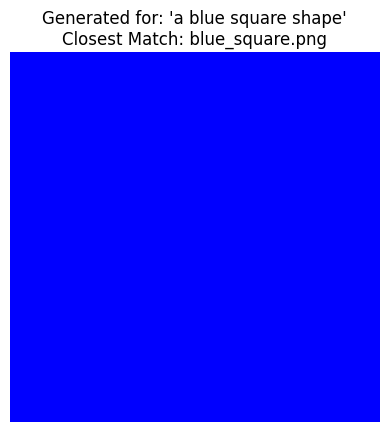

In [14]:
print("\nStep 4.3: Finding closest known image...")

# --- Calculate Distances --- 
# Theory: Calculate the distance between the predicted vector and each known vector.
# We use Cosine distance: 1 - cosine_similarity. Smaller distance is better.
predicted_vec = predicted_feature_vector.squeeze(0).cpu().numpy() # Move to CPU and convert to numpy for scipy

min_distance = float('inf')
closest_image_path = None

for known_path, known_vec_tensor in known_features_list:
    known_vec = known_vec_tensor.cpu().numpy()
    # Calculate cosine distance
    # dist = scipy_distance.cosine(predicted_vec, known_vec)
    # Or Calculate Euclidean distance (L2 norm)
    dist = scipy_distance.euclidean(predicted_vec, known_vec)

    # print(f"  Distance to {os.path.basename(known_path)}: {dist:.4f}") # Optional: print distances

    if dist < min_distance:
        min_distance = dist
        closest_image_path = known_path

# --- Display Result --- 
if closest_image_path:
    print(f"Closest match found: '{os.path.basename(closest_image_path)}' with distance {min_distance:.4f}")
    # Display the image using PIL or matplotlib
    try:
        matched_img = Image.open(closest_image_path)
        print("Displaying the closest matching image:")
        # In a notebook environment, simply displaying the object often works:
        # matched_img 
        # Or use matplotlib:
        import matplotlib.pyplot as plt
        plt.imshow(matched_img)
        plt.title(f"Generated for: '{generation_prompt_text}'\nClosest Match: {os.path.basename(closest_image_path)}")
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"Error: Could not load the matched image file at {closest_image_path}")
    except Exception as e:
        print(f"Error displaying image: {e}")
else:
    print("Could not determine the closest image.")

### Step 5: Save the model state (optional)

To save our text to image generation model, you need to create a dictionary with all model components and configurations, then use torch.save(). Here's how to do it:

In [15]:
import os

# Create the directory if it doesn't exist
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'text_to_image_model.pt')

# Create a dictionary with all relevant components and configurations
text_to_image_state_dict = {
    # Configuration
    'config': {
        'vocab_size': vocab_size,
        'd_model': d_model,
        'n_heads': n_heads,
        'n_layers': n_layers,
        'd_ff': d_ff,
        'block_size': block_size,
        'vision_feature_dim': vision_feature_dim
    },
    # Tokenizer
    'tokenizer': {
        'char_to_int': char_to_int,
        'int_to_char': int_to_char
    },
    # Model weights (trainable parts)
    'token_embedding_table': token_embedding_table.state_dict(),
    'positional_encoding': positional_encoding, # Not trained, but needed for reconstruction
    'layer_norms_1': [ln.state_dict() for ln in layer_norms_1],
    'mha_qkv_linears': [l.state_dict() for l in mha_qkv_linears],
    'mha_output_linears': [l.state_dict() for l in mha_output_linears],
    'layer_norms_2': [ln.state_dict() for ln in layer_norms_2],
    'ffn_linear_1': [l.state_dict() for l in ffn_linear_1],
    'ffn_linear_2': [l.state_dict() for l in ffn_linear_2],
    'final_layer_norm': final_layer_norm.state_dict(),
    'text_to_image_feature_layer': text_to_image_feature_layer.state_dict() # The new output layer
    # Note: We don't save the frozen vision_model weights here, 
    # as we assume it's loaded separately from torchvision during use.
}

# Save to file
torch.save(text_to_image_state_dict, save_path)
print(f"Text-to-Image model saved to {save_path}")

Text-to-Image model saved to saved_models\text_to_image_model.pt


### Loading the Saved Text-to-Image Model

To load the model back, you would reverse the saving process:

In [16]:
# Load the saved state dictionary
load_path = 'saved_models/text_to_image_model.pt'
if os.path.exists(load_path):
    loaded_t2i_state = torch.load(load_path, map_location=device)
    print(f"Loaded state dictionary from '{load_path}'.")

    # Extract configuration and tokenizer
    config = loaded_t2i_state['config']
    vocab_size = config['vocab_size']
    d_model = config['d_model']
    n_heads = config['n_heads']
    n_layers = config['n_layers']
    d_ff = config['d_ff']
    block_size = config['block_size']
    vision_feature_dim = config['vision_feature_dim']
    d_k = d_model // n_heads

    char_to_int = loaded_t2i_state['tokenizer']['char_to_int']
    int_to_char = loaded_t2i_state['tokenizer']['int_to_char']

    # Recreate causal mask
    causal_mask = torch.tril(torch.ones(block_size, block_size, device=device)).view(1, 1, block_size, block_size)

    # Rebuild and load model components
    token_embedding_table = nn.Embedding(vocab_size, d_model).to(device)
    token_embedding_table.load_state_dict(loaded_t2i_state['token_embedding_table'])

    positional_encoding = loaded_t2i_state['positional_encoding'].to(device)

    layer_norms_1 = []
    mha_qkv_linears = []
    mha_output_linears = []
    layer_norms_2 = []
    ffn_linear_1 = []
    ffn_linear_2 = []

    for i in range(n_layers):
        # Load Layer Norm 1
        ln1 = nn.LayerNorm(d_model).to(device)
        ln1.load_state_dict(loaded_t2i_state['layer_norms_1'][i])
        layer_norms_1.append(ln1)
        
        # Load MHA QKV Linear
        qkv_dict = loaded_t2i_state['mha_qkv_linears'][i]
        has_bias = 'bias' in qkv_dict
        qkv = nn.Linear(d_model, 3 * d_model, bias=has_bias).to(device)
        qkv.load_state_dict(qkv_dict)
        mha_qkv_linears.append(qkv)

        # Load MHA Output Linear
        mha_out_dict = loaded_t2i_state['mha_output_linears'][i]
        has_bias = 'bias' in mha_out_dict
        mha_out = nn.Linear(d_model, d_model, bias=has_bias).to(device)
        mha_out.load_state_dict(mha_out_dict)
        mha_output_linears.append(mha_out)

        # Load Layer Norm 2
        ln2 = nn.LayerNorm(d_model).to(device)
        ln2.load_state_dict(loaded_t2i_state['layer_norms_2'][i])
        layer_norms_2.append(ln2)

        # Load FFN Linear 1
        ffn1_dict = loaded_t2i_state['ffn_linear_1'][i]
        has_bias = 'bias' in ffn1_dict
        ff1 = nn.Linear(d_model, d_ff, bias=has_bias).to(device)
        ff1.load_state_dict(ffn1_dict)
        ffn_linear_1.append(ff1)

        # Load FFN Linear 2
        ffn2_dict = loaded_t2i_state['ffn_linear_2'][i]
        has_bias = 'bias' in ffn2_dict
        ff2 = nn.Linear(d_ff, d_model, bias=has_bias).to(device)
        ff2.load_state_dict(ffn2_dict)
        ffn_linear_2.append(ff2)

    # Load Final LayerNorm
    final_layer_norm = nn.LayerNorm(d_model).to(device)
    final_layer_norm.load_state_dict(loaded_t2i_state['final_layer_norm'])

    # Load Text-to-Image Feature Layer
    t2i_out_dict = loaded_t2i_state['text_to_image_feature_layer']
    has_bias = 'bias' in t2i_out_dict
    text_to_image_feature_layer = nn.Linear(d_model, vision_feature_dim, bias=has_bias).to(device)
    text_to_image_feature_layer.load_state_dict(t2i_out_dict)
    
    print("Text-to-Image model components loaded successfully.")

    # Remember to also load the vision_model separately if needed for targets/comparison
    # vision_model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    # vision_model.fc = nn.Identity()
    # vision_model = vision_model.to(device)
    # vision_model.eval()
    # for param in vision_model.parameters():
    #     param.requires_grad = False
else:
    print(f"Model file not found at {load_path}. Cannot load model.")

Loaded state dictionary from 'saved_models/text_to_image_model.pt'.
Text-to-Image model components loaded successfully.


### Step 6: Conclusion

This notebook demonstrated a highly simplified, inline approach to text-to-image generation using a Transformer architecture. Instead of generating raw pixels, we adapted the pre-trained text Transformer to predict an *image feature vector* corresponding to a textual description.

Key steps involved:
1.  **Loading:** Reusing text Transformer components and the ResNet feature extractor from the previous multi-modal model.
2.  **Data:** Defining text prompts paired with target images and pre-extracting the *target* image feature vectors using the frozen ResNet.
3.  **Architecture Adaptation:** Replacing the final output layer of the Transformer with a new linear layer projecting hidden states to the image feature dimension.
4.  **Training:** Training the Transformer components and the new output layer to minimize the Mean Squared Error (MSE) between the *predicted* image feature vector and the *target* image feature vector for given text prompts.
5.  **Generation & Simplified Reconstruction:** Using the trained model to predict a feature vector from a new text prompt. Then, finding the training image whose actual feature vector is closest (using Euclidean distance) to the predicted vector and displaying that image as the result.

This method illustrates the concept of using Transformers for cross-modal generation (text to a visual representation) while adhering to the inline implementation constraint. It avoids the significant complexity of direct pixel generation (GANs, Diffusion) but provides a tangible, albeit very basic, visual output by leveraging nearest-neighbor search in the feature space of known images. Real-world text-to-image models are vastly more complex, often combining different architectures and trained on enormous datasets.